In [1]:
"""Evaluates feature attributes of a adversarialy trained model against adv attack"""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from datetime import datetime
import json
import math
import os
import sys
import time

import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

import PIL
import matplotlib.pyplot as plt
from numpy import linalg as LA
import numpy as np

from model import Model

from tensorflow.python import pywrap_tensorflow
from tensorflow.python.ops.parallel_for.gradients import jacobian


In [20]:
model_dir = "./models/nat"

num_examples = 10000
# eval_batch_size = 200


In [3]:
tf.reset_default_graph()
model = Model()
checkpoint = tf.train.latest_checkpoint(model_dir)
reader=pywrap_tensorflow.NewCheckpointReader(checkpoint)
saver = tf.train.Saver()

Instructions for updating:
Colocations handled automatically by placer.


In [4]:
config = tf.ConfigProto()
config.log_device_placement=False
config.allow_soft_placement=True
config.gpu_options.allow_growth=True

session = tf.Session(config=config)
session.run(tf.global_variables_initializer())
saver.restore(session, checkpoint)

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./models/nat/checkpoint-7800


In [15]:
test_path = "./adv_test/pgd/xent/nat/03.npy"
adv_test = np.load(test_path)

mnist = input_data.read_data_sets('MNIST_data', one_hot=False)
true_labels = mnist.test.labels

# train_total_data = np.column_stack((adv_test,true_labels))

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [16]:
labeled_pred = model.softmax_layer[:,model.y_input[0]]
grad = tf.gradients(labeled_pred, model.x_input)
def integrated_gradient(img, target_label_index, steps = 50, baseline=None):
    if baseline is None:
        baseline = 0*img
    assert(baseline.shape == img.shape)
    steps=steps

    # Scale input and compute gradients.
    scaled_inputs = [baseline + (float(i)/steps)*(img-baseline) for i in range(0, steps+1)]

    gradient = session.run(grad, feed_dict = {model.x_input:np.squeeze(scaled_inputs),model.y_input:target_label_index})
    avg_grads = np.average(gradient[0][:-1], axis=0)
    integrated_gradients = (img-baseline)*avg_grads  # shape: <inp.shape>
    return integrated_gradients

In [17]:
feature_attributions = []
for i in range(num_examples):
    x = adv_test[i]
    y = session.run(model.y_pred, feed_dict={model.x_input: [adv_test[idx]]})[0]
    feature_attributions.append(integrated_gradient(x, [y]))

[3]


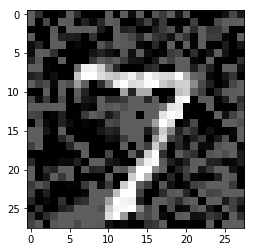

In [18]:
idx = 0
plt.imshow(np.resize(adv_test[idx],[28,28]), cmap='Greys_r')
print(session.run(model.y_pred, feed_dict={model.x_input: [adv_test[idx]], model.y_input: [mnist.train.labels[idx]]}))

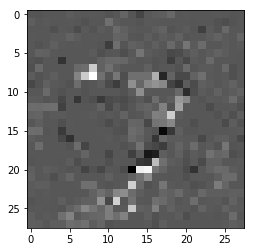

In [19]:
plt.imshow(np.resize(feature_attributions[0],[28,28]), cmap='Greys_r')

In [ ]:
print('Storing examples')
path = "./features/02/feature_attributions.npy"
feature_attributions = np.asarray(feature_attributions)
np.save(path, feature_attributions)
print('Examples stored in {}'.format(path))